# Subspace Inference

Nicholas Beasley, Nam Luu, Andrew Fu, Ralph Tigoumo

# Writeup

## Problem Statement and Motivation

As we learned in class, sampling from or approximating the posterior of neural network weights is very difficult. The posterior is often very complex and high-dimensional, making sampling methods like HMC slow and inefficient (not to mention the problems with convergence). Furthermore, both sampling and approximation techniques like variational inference suffer from poor representations of uncertainty. The posterior predictives of these techniques typically don't show increases in uncertainty in regions with less data. 

This paper seeks to solve both of these problems by providing a method for Bayesian inference on the weights of deep neural networks that is computationally efficient/fast and has well-calibrated uncertainty. 

<br>

## Existing Literature
There have been several attempts so far in coming up with efficient and scalable Bayesian Deep Learning. Subspace inference, which so far has proven to be both computationally efficient and producing highly accurate predictive distributions, builds upon a previous Bayesian Deep Learning method called Stochastic Weight Averaging Gaussian (SWAG). In SWAG, the SGD iterates' moving average and covariance matrix are used as the parameters of a Gaussian which is used as the posterior distribution of the neural network. This works well but constrains the shape of the posterior over the weights to be Gaussian, which might be detrimental to accuracy and uncertainty estimation.

Subspace building in the paper also makes use of near-constant low loss curves in weight subspaces, which were built by optimization in the parameter space. This technique was originally intended for ensembling and was called Fast Geometric Ensembling (FGE), but the authors of this paper only make use of the curve subspace used in FGE to perform Bayesian inference.

Other methods also used FGE for Bayesian Inference but they did so by training multiple models with FGE and then performing variational inference on the subspace formed by all these models. This method however is computationally expensive compared to subspace inference.

Finally, some methods perform efficient Bayesian inference on the dataset rather than on the parameter space. These are done by using linear combinations of the dataset or by projecting the data using linear regression settings.

<br>

## Contribution 
This paper contributes a novel method for Bayesian inference on neural network weights that the authors claim to be efficient and well-calibrated in terms of uncertainty. Traditional methods for Bayesian inference on deep (many layers/nodes) neural networks are either computationally intractable (sampling) or poorly calibrated (variational inference), so the paper makes a contribution by solving both issues.


-----


## High-level Summary
The main idea is that it is possible to choose a particular low-dimensional subspace of the weight space, such that sampling from or approximating the posterior over the subspace is tractable. Furthermore, it is possible to choose this subspace such that a variety of models are captured, meaning that there will be higher levels of uncertainty away from the data, as we might expect intuitively. 

The authors choose the ``origin" of the subspace by training the model using SGD. The three main ways they choose the basis vectors of the subspace are:
* Selecting random, normally distributed basis vectors in the weight space.
* Using PCA on the trajectory of SGD. Intuitively, SGD steps indicate the direction in which loss decreases the most. Taking the principal components means that the loss function varies the most in those directions, resulting in a diverse set of models.
* "Curve subspace". Take two converged SGD solutions and a path in a parametrized subspace between them which has low loss. The 2D subspace that contains the curve has high model diversity as well.

After choosing the subspace, the authors choose a prior (the choice is actually not very important, a Gaussian will usually work) and compute the likelihood of data by transforming from the subspace to the original weight space. With this information, standard approximate inference methods like MCMC and variational inference can then be applied to sample from the posterior over the subspace.  

<br>

## Technical Details

Subspace inference for Bayesian Deep Learning consists of 2 major steps: building a subspace from SGD weight iterates and then sampling from this subspace using standard sampling techniques such as HMC, No-U-Turn Sampler, and Elliptical Slice Sampling, and finally variational inference. 
In a nutshell, a subspace is simply a $k \times D$ matrix, together with a shift vector $\hat{w}$, which is the Stochastic Weighted Average (SWA) of the weights. Below we dive into the details of how each subspace is built, and then cover how sampling is done on these subspaces:

#### Random Subspace:
The random subspace is built by creating a random matrix $P$ of dimensions $k \times D$, where $k$ is the dimension of the subspace, and $D$ is the dimension of the flattened neural network weight vector. Each of the $k$ vectors are then normalized, and the moving average of all the last M epoch weights is used as a shift vector, in order to center weights in regions of good models in the weight space. The shift vector and the projection matrix are then used for sampling in the subspace.

#### PCA Subspace:
The PCA Subspace is built by creating a deviance matrix of dimensions $M \times D$ ($A$), and then applying PCA to it to produce a $k \times D$ matrix of rank $k$. The deviance matrix is calculated by taking the difference between the moving average and the current epoch's trained weight vector, $a_i = w_{SWA} - w_i$ and appending this vector as a row to the deviance matrix. Only the deviance of the weights of the last M epochs are added to the $M \times D$ matrix. 

After building $A$, truncated SVD is applied to produce $U, S, V^T$ matrices, and the resulting $P$ matrix is then used as the matrix for the PCA subspace. The PCA subspace also uses the same shift vector, $w_{SWA}$, the Stochastic Weighted Average of the weights during building of the deviance matrix.

#### Curve Subspace:
The curve subspace is formed first by parametrizing the weight vectors of two SGD converged solutions and forming a two dimensional subspace. The new basis for the subspace $v_1$ and $v_2$ are found by setting $v_1 = (w_0 - \hat{w}) / ||w_0 - \hat{w}||$ and $v_2 = (w_{1/2} - \hat{w}) / ||w_{1/2} - \hat{w}||$, where $w_0$ and $w_1$ are the weights of two converged SGD trials, and $w_{1/2}$ is the midpoint of the curve.

Next, a curve is found by optimization in this subspace which contains a variety of near-constant low training loss and testing errors. Such a curve is very simple containing only one bend, therefore making it computationally easy to find. However, this subspace creation technique is the most expensive subspace to build because 2 or 3 models have to be trained, and an expensive optimization process needs to be run to find the curve; but it is also the subspace with highest accuracy after sampling from it using HMC (NUTS), Black Box Variational Inference or Elliptical Slice Sampling.

### Sampling from subspaces
Once subspaces have been built using curve finding, generating a random matrix for random subspace, or doing PCA on the deviance matrix for PCA subspace, standard samplers can then be used to sample vectors from the subspaces, which are then converted back into weight vectors for the neural network and then used to make predictions. Accepted weight samples then form a distribution of weights, which can then be used to form a predictive distribution.

The samplers all make use of a simple Gaussian with mean 0, and variance of 1. The PCA subspace however has a higher variance prior, most likely due to the fact that the PCA vectors have norms proportional to the singular values of the deviance matrix A.

To obtain a Neural Network weight vector $w$ from the subspace given a subspace vector $z$, we add the shift vector to the product of $P$ and $z$, like in the formula below:

$$w = \hat{w} + Pz$$

This transformation from the subspace to the parameter space is non-invertible, and is mainly done during sampling.

Furthermore, because the number of vectors in the weight space is usually much smaller than the number of data points (the authors only use subspaces of dimensions $k = 10$ in their examples), it's important to prevent concentration of the posterior on the MLE solution. To do this, the authors suggest using a tempered posterior, like in the following equation:

$$p_T(z|\mathcal{D}) \propto p(\mathcal{D}|z)^{1/T} p(z)$$

-----


## Experiments
The authors used a complicated (hidden layers of 200, 50, 50, 50 neurons) neural network with Gaussian noise to generate a toy 2-D dataset. They then trained a neural network with the same architecture on this dataset and constructed a random subspace, PCA subspace, and curve subspace centered at this solution. For each subspace, they sampled from the posterior using elliptical slice sampling and visualized the posterior predictives. This toy example provides a nice visualization of the authors' claim that uncertainty estimation is improved with PCA and curve subspace methods; Figure 3 (reproduced below) supports this claim by showing that methods like variational inference do not show increased uncertainty in regions with no data, while PCA and curve subspace inference do. 

As a second experiment, the authors used a more complex neural network on regression datasets created by UC Irvine. They trained the neural network on 90\% of the dataset and held out a random 10\% for testing. When comparing the log-likelihood and RMSE of the test data across different models, they find that Bayesian model averaging using subspace inference generates log-likelihoods and RMSEs that are on par with or better than those from SGD. This demonstrates that their proposed method, though efficient, does not sacrifice accuracy. 

The final experiment the authors perform also serves to test performance. They use subspace inference for image classification and find that accuracy and log-likelihood are comparable to other state-of-the-art methods. This is unsurprising as they use standard training procedures to find the offset of the subspaces sampled (and thus are centered around a region with low loss) and is not necessarily informative of the power of their method in estimating epistemic uncertainty.


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
# %cd 'drive/My Drive/subspace-inference'

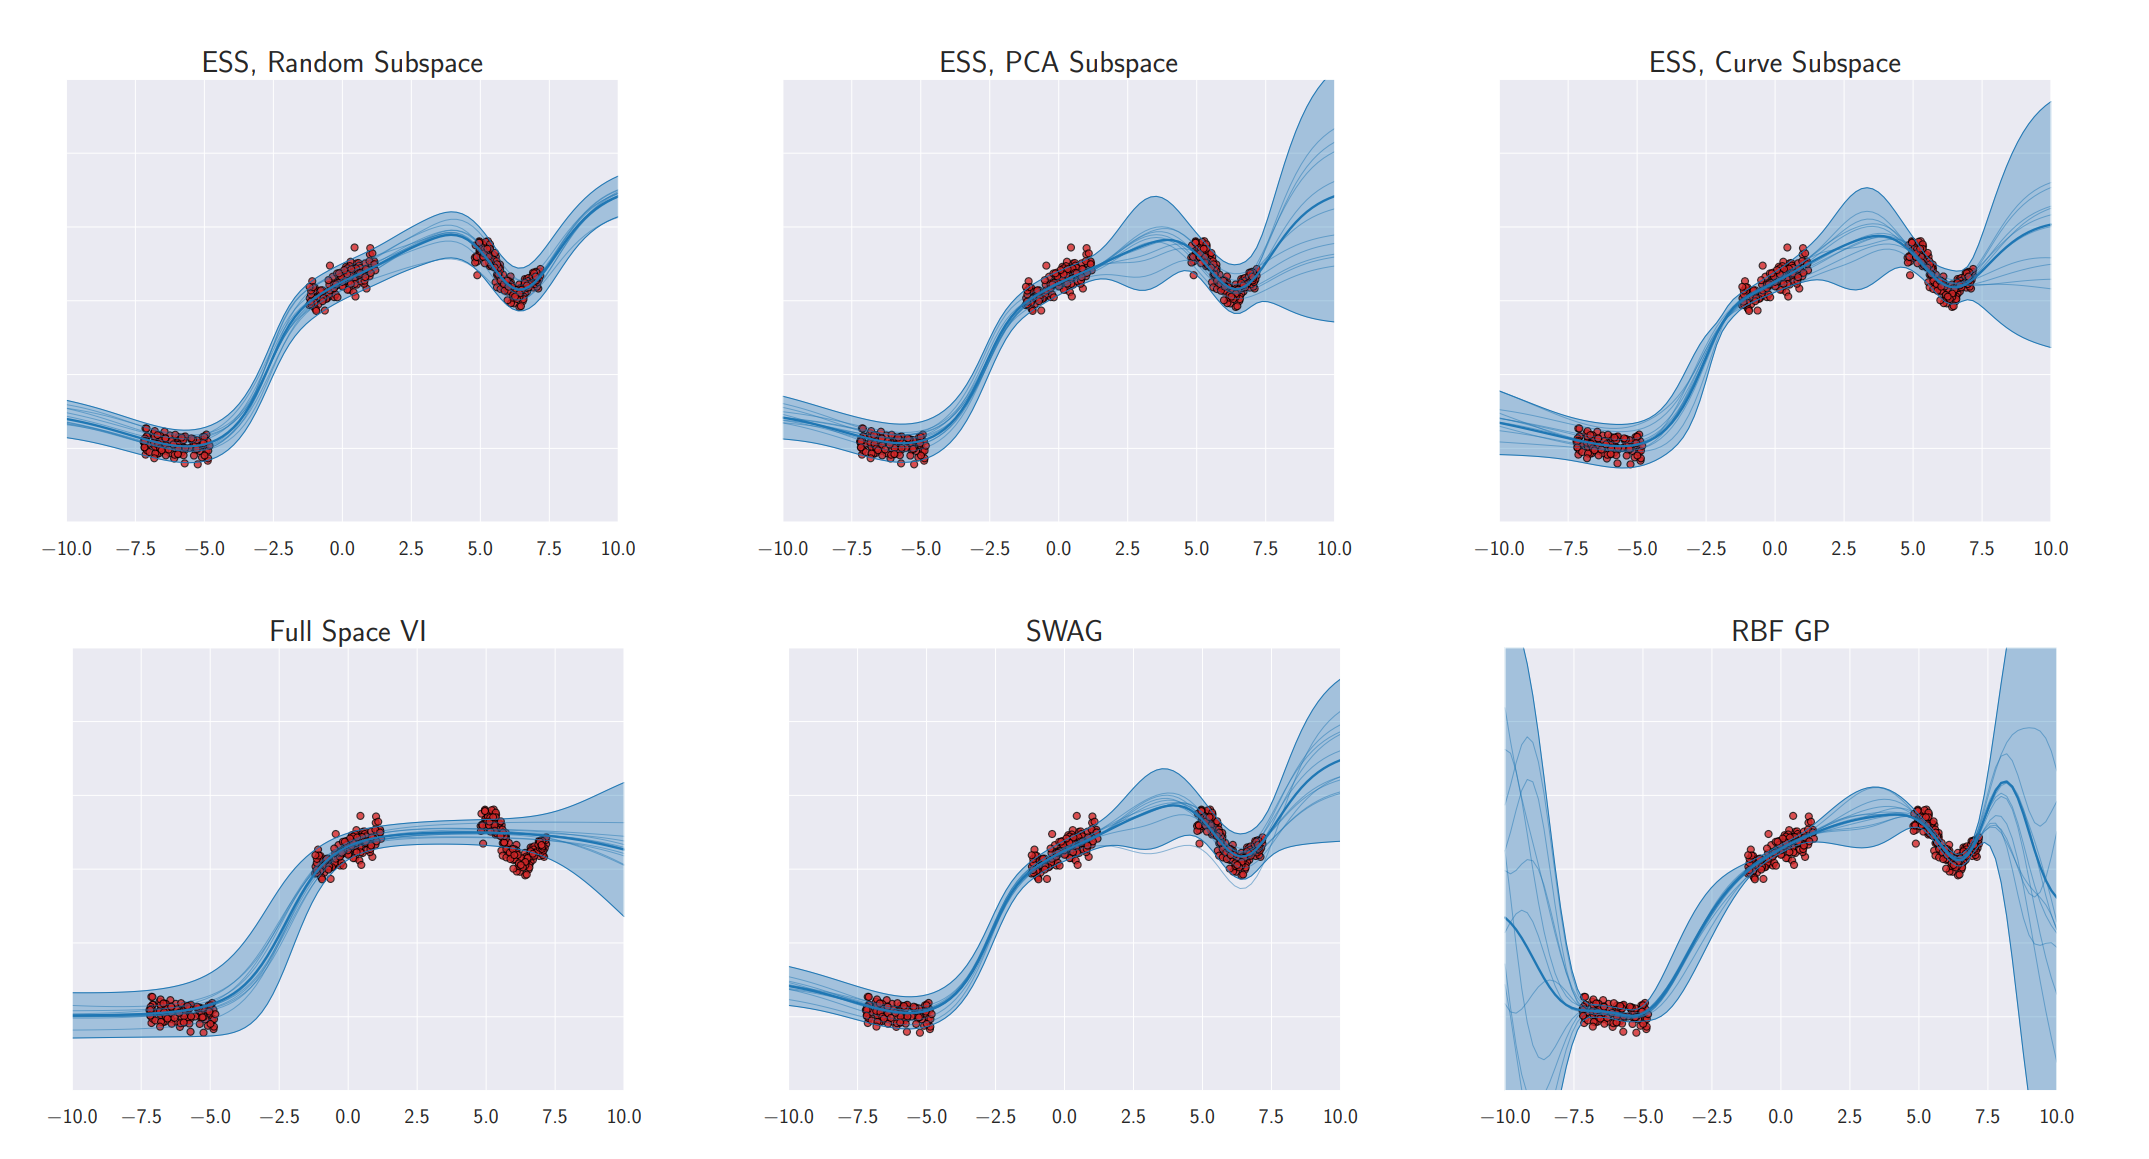

In [3]:
from IPython.display import Image
Image(filename="Uncertainty.png",width=1000)

## Evaluation
The proposed method is certainly practical, as it involves inference over very low-dimensional subspaces. For instance, some of the image classifications were done using a PCA subspace with just 10 dimensions and a curve subspace of just 2 dimensions! In this low-dimensional environment, the authors were able to use existing techniques like SWAG, ESS, and NUTS and still properly explore the posterior while getting high accuracy.  \\

While the experimental section provided strong evidence of the performance of Bayesian model averaging/subspace inference, its evidence of well-calibrated uncertainty was a little less convincing. The main evidence given by the authors was figures of the posterior predictive for the toy regression. The posterior predictives created by subspace inference generated wider uncertainty intervals in regions with no data, but it was unclear if these results would generalize to higher-dimensional data. Furthermore, it was hard to determine how "good" the uncertainty calibration was because there are no ways (that we know of or that the paper cited) of measuring the "proper" level uncertainty numerically. 

# Code

This section contains our pedagogical example and bare-bones implementation of random/PCA subspace inference.

In [4]:
import pandas as pd
import numpy
import autograd.numpy as np
import matplotlib.pyplot as plt

import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd

from nn_models import Feedforward
from alpha_hmc import HMC
# from utils.bbvi import black_box_variational_inference

## Pedagogical Example

We create a toy dataset similar to the one used in the paper and show that our bare-bones implementation of subspace inference solves the problem addressed by the authors.

In [5]:
# Read in the data
df = pd.read_csv('data/data.csv')
X_train = df['x'].values.reshape((1, -1))
Y_train = df['y'].values.reshape((1, -1))

df.head()

,x,y
0,-2.637265,-8.239801
1,-2.894060,-12.641946
2,-2.721683,-8.723363
3,-2.757217,-10.020260
4,-2.684268,-8.747958


In [6]:
###define sigmoid activation function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

###neural network model design choices
width = 10
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'sigmoid',
               'activation_fn_params': '',
               'activation_fn': sigmoid}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=np.random.RandomState(rand_state))

In [7]:
###define design choices in gradient descent
params = {'step_size':1e-1, 
          'max_iteration':5000, 
          'random_restarts':1}

# Fit the neural network to minimize MSE on the given data
nn.fit(X_train, Y_train, params)

Iteration 0 lower bound 2753.366147266781; gradient mag: 1046.9368914715233
Iteration 100 lower bound 73.20265466242073; gradient mag: 17.75526855393434
Iteration 200 lower bound 25.10853518782951; gradient mag: 5.629493699410229
Iteration 300 lower bound 18.18302520270782; gradient mag: 2.8809380232149717
Iteration 400 lower bound 15.93806085941476; gradient mag: 22.467461430708212
Iteration 500 lower bound 15.131504065700744; gradient mag: 0.7856124668101464
Iteration 600 lower bound 14.892721491294155; gradient mag: 0.42055887748602105
Iteration 700 lower bound 14.789303465279446; gradient mag: 2.5176531042255137
Iteration 800 lower bound 14.727681148675092; gradient mag: 0.20524477049080886
Iteration 900 lower bound 14.930925115681006; gradient mag: 40.34266324548923
Iteration 1000 lower bound 14.661561846942927; gradient mag: 0.1737785363652978
Iteration 1100 lower bound 14.640335994505794; gradient mag: 0.11850516700739222
Iteration 1200 lower bound 14.625787855900938; gradient m

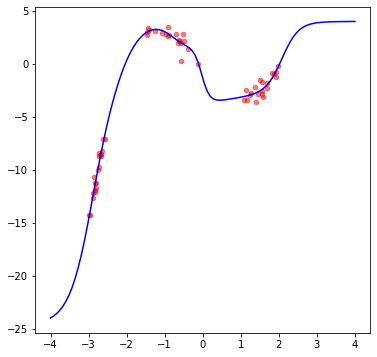

In [8]:
# Plot the results over the relevant domain
X_eval = np.linspace(-4, 4, 100).reshape(1,-1)
Y_eval = nn.forward(nn.weights, X_eval)

plt.figure(figsize=(6,6))
plt.scatter(X_train, Y_train, s=20, alpha=0.5, c='r')
plt.plot(X_eval.flatten(), Y_eval.flatten(), c='b')
plt.show()

## Random Subspace

In [9]:
# Treat z as a 1x2 row vector
# Get all 31 weights and biases (pre-trained), this is w_hat
from autograd import numpy as np
all_weights = nn.weights


# Store as a 1x31 numpy array
D = len(all_weights)


#------------------------------------------------------------------------------#
# Draw 2 normal random basis vectors in R^31, normalize them and make them 
# column vectors
P_random = random.normal(size=(2,31)) # Projection matrix
P_random = P_random / np.linalg.norm(P_random)

# Function that takes z and returns corresponding w
def z_to_w(z, P):
    return all_weights + np.matmul(z, P)


#------------------------------------------------------------------------------#
# Log(posterior) is proportional to log(prior)+log(likelihood)
# Definition of the log prior for z (normal distribution, variance matrix = I)
def log_prior(z):
    return -0.5 * (np.sum(z**2) + 2 * np.log(2 * np.pi))

# Definition of the log-likelihood of data given z
def log_lklhd(z, P):
    # Get weights w corresponding to subspace vector z
    weights = z_to_w(z, P)
        
    # Like in HW 7, data point y_n is normally distributed 
    # with mean nn(x_n), variance 0.5^2
    return 0.5 * np.log(2 / np.pi) - 2 * np.sum(
        (Y_train - nn.forward(weights,X_train)) ** 2
        )    
    


In [10]:
#potential energy function, with temperature
T = 10
def potential_energy_random(z):
    return -1 * (log_lklhd(z, P_random) / T + log_prior(z))

#kinetic energy function
def kinetic_energy(z):
    return np.sum(z**2) / 2.0
    
#the gibbs distribution of the kinetic energy function
def kinetic_energy_distribution(n):
    # size = 2 because that's the dimension of z
    return random.normal(0, 1, size=2) 

In [11]:
# Initialize the position vector for HMC sampling with the weights of the 
# trained neural network (i.e. z=0, so w=w_hat)
# z is centered "well", so might as well start off with zero vector
position_init = np.zeros((1,2)) 

#leap-frog step size
step_size = 5e-2
#leap-frog steps
leapfrog_steps = 20
#number of total samples after burn-in
total_samples = 10000
#percentage of samples to burn
burn_in = 0.20
#thinning factor
thinning_factor = 2


#instantiate an HMC sampler
HMC_sampler = HMC(potential_energy_random, kinetic_energy,
                  kinetic_energy_distribution,
                  random=np.random.RandomState(rand_state))

#sample from the bayesian neural network posterior
HMC_sampler.sample(position_init=position_init,
                   step_size=step_size,
                   leapfrog_steps=leapfrog_steps,
                   total_samples=total_samples,
                   burn_in=burn_in,
                   thinning_factor=thinning_factor)

HMC 100: accept rate of 84.0 with step size 0.05
HMC 200: accept rate of 78.0 with step size 0.052500000000000005
HMC 300: accept rate of 77.66666666666666 with step size 0.052500000000000005
HMC 400: accept rate of 78.0 with step size 0.052500000000000005
HMC 500: accept rate of 79.0 with step size 0.052500000000000005
HMC 600: accept rate of 76.66666666666667 with step size 0.052500000000000005
HMC 700: accept rate of 76.85714285714286 with step size 0.052500000000000005
HMC 800: accept rate of 76.625 with step size 0.052500000000000005
HMC 900: accept rate of 75.77777777777777 with step size 0.052500000000000005
HMC 1000: accept rate of 76.3 with step size 0.052500000000000005
HMC 1100: accept rate of 76.9090909090909 with step size 0.052500000000000005
HMC 1200: accept rate of 77.0 with step size 0.052500000000000005
HMC 1300: accept rate of 77.0 with step size 0.052500000000000005
HMC 1400: accept rate of 76.78571428571429 with step size 0.052500000000000005
HMC 1500: accept rate 

(52, 52)
(52, 52)
(52, 52)


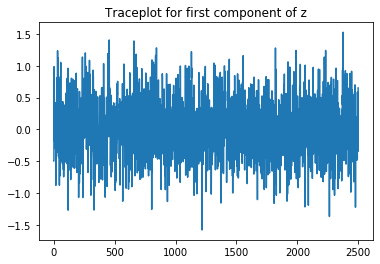

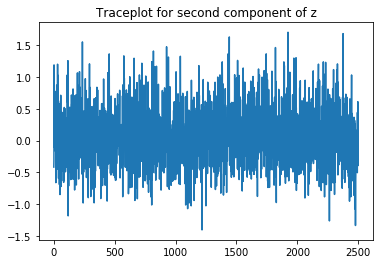

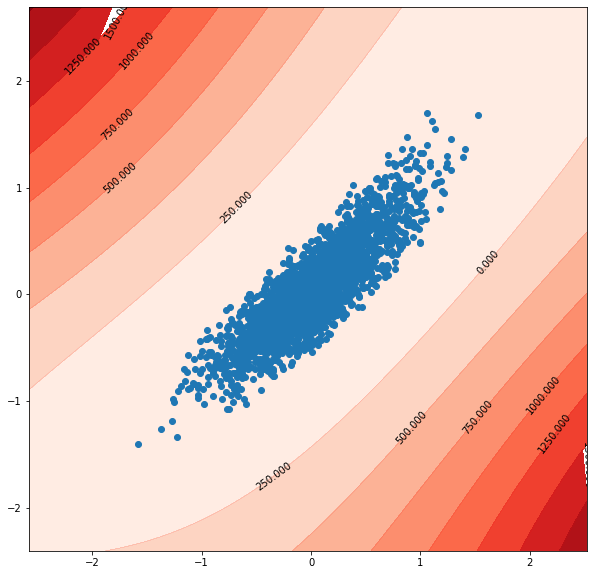

In [12]:
# Traceplots
plt.figure()
plt.title('Traceplot for first component of z')
plt.plot(HMC_sampler.trace[:, 0])

plt.figure()
plt.title('Traceplot for second component of z')
plt.plot(HMC_sampler.trace[:, 1])


# Plot samples in x-y plane over contour map of potential energy (like in paper)
def new_log_prior(z):
    return -0.5 * (np.dot(z, np.transpose(z)) + 2 * np.log(2 * np.pi))

def new_potential_energy_random(z):
    #print(z)
    return -1 * (log_lklhd(z, P_random) + new_log_prior(z))


# Define contour map range (slightly larger than min/max of samples)
x, y = numpy.mgrid[
    min(HMC_sampler.trace[:, 0]) - 1:max(HMC_sampler.trace[:, 0]) + 1:.1, 
    min(HMC_sampler.trace[:, 1]) - 1:max(HMC_sampler.trace[:, 1]) + 1:.1
]
pos = numpy.dstack((x, y))

print(x.shape)
print(y.shape)

# Get the potential energy at the mesh points
z = np.zeros(x.shape)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = new_potential_energy_random(np.array([x[i, j],y[i, j]]))
    
print(z.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Create the potential energy contour map with labels
CS = ax.contourf(x,y,z, cmap='Reds')
ax.clabel(CS,fontsize=10,colors='black')
ax.contour(x,y,z, linewidths=0.1, colors='red')

# Make scatter plot of HMC samples over contour map
plt.scatter(HMC_sampler.trace[:,0],HMC_sampler.trace[:,1])
plt.show()

Text(0, 0.5, 'y')

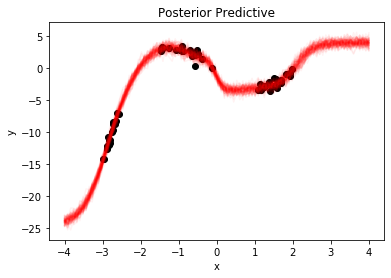

In [13]:
# Take samples of posterior weights
N = len(HMC_sampler.trace)
n_samples = 100

x_test = np.linspace(-4, 4, 100).reshape(1,-1)

# For each of 100 samples, plot output from test data with some noise added
for i in range(n_samples):
    sample = np.array([HMC_sampler.trace[random.randint(N),:]]) # Sample weights
    
    weights = z_to_w(sample, P_random)
    
    # Use these weights in the NN
    y_test = nn.forward(weights,x_test).flatten()
    y_test += random.normal(0,0.5,size=100) # Add noise to prediction
    
    plt.plot(x_test.flatten(),y_test, color='red',alpha=0.05)
    
# Also plot our original data
plt.scatter(X_train, Y_train, color='black', label='data')  
plt.title('Posterior Predictive')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

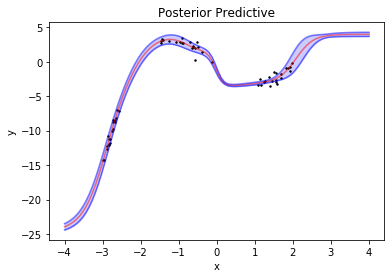

In [14]:
# Make a similar plot, but with predictive mean +/- 3 SDs (like in the paper)
# For each of 100 samples, plot output from test data with some noise added
x_test = np.linspace(-4, 4, 100).reshape(1,-1)

n_samples = 100
all_samples = np.zeros((n_samples,x_test.shape[1]))

for i in range(n_samples):
    sample = np.array([HMC_sampler.trace[random.randint(N),:]]) # Sample weights
    
    weights = z_to_w(sample, P_random)
    
    # Use these weights in the NN
    all_samples[i,:] = nn.forward(weights,x_test).flatten()

plot1 = np.mean(all_samples,axis=0)  
plot2 = np.mean(all_samples,axis=0)+3*np.std(all_samples,axis=0)
plot3 = np.mean(all_samples,axis=0)-3*np.std(all_samples,axis=0)

plt.plot(x_test.flatten(),plot1, color='red',alpha=0.5)    
plt.plot(x_test.flatten(),plot2, color='blue',alpha=0.5)
plt.plot(x_test.flatten(),plot3, color='blue',alpha=0.5)
plt.fill_between(x_test.flatten(), plot2, plot3, color='blue', alpha=0.2)    

# Also plot our original data
plt.scatter(X_train, Y_train, color='black', label='data', s=2)  
plt.title('Posterior Predictive')
plt.xlabel('x')
plt.ylabel('y')


## PCA Subspace

In [15]:
#Perform SGD from pre-trained solution
sgd_trace = list()

def sgd_objective(weights, epoch):
    total_data = np.size(X_train)
    rand_index = random.randint(low=0, high=total_data)
    return np.sum(np.square(np.linalg.norm(
        (Y_train[:, rand_index:rand_index + 1] 
         - nn.forward(weights, X_train[:, rand_index:rand_index + 1])),
        axis=1
        )))
    
sgd(grad(sgd_objective), nn.weights.reshape((1, -1)),
    callback=lambda x, i, g: sgd_trace.append(x), num_iters=20, step_size=1e-1, 
    mass=0)


last_weights = np.array(sgd_trace)
last_weights = last_weights.reshape((last_weights.shape[0], -1))
_, s, vh = np.linalg.svd(last_weights - all_weights)
P_pca = np.diag(s[:2]) @ vh[:2]
# Construct subspace from first two principal components
P_pca *= 10 / np.linalg.norm(P_pca)
position_init_pca = np.zeros((1, 2))

def potential_energy_pca(z):
    T = 30
    return -1 * (log_lklhd(z, P_pca) / T + log_prior(z))

#instantiate an HMC sampler
HMC_sampler_pca = HMC(potential_energy_pca, kinetic_energy,
                  kinetic_energy_distribution,
                  random=np.random.RandomState(rand_state))

#sample from the bayesian neural network posterior
HMC_sampler_pca.sample(position_init=position_init_pca,
                       step_size=1e-2,
                       leapfrog_steps=10,
                       total_samples=10000,
                       burn_in=burn_in,
                       thinning_factor=thinning_factor)

HMC 100: accept rate of 75.0 with step size 0.01
HMC 200: accept rate of 72.5 with step size 0.01
HMC 300: accept rate of 71.0 with step size 0.01
HMC 400: accept rate of 70.75 with step size 0.01
HMC 500: accept rate of 70.19999999999999 with step size 0.01
HMC 600: accept rate of 70.66666666666667 with step size 0.01
HMC 700: accept rate of 70.42857142857143 with step size 0.01
HMC 800: accept rate of 70.625 with step size 0.01
HMC 900: accept rate of 70.11111111111111 with step size 0.01
HMC 1000: accept rate of 70.1 with step size 0.01
HMC 1100: accept rate of 69.72727272727272 with step size 0.01
HMC 1200: accept rate of 69.25 with step size 0.01
HMC 1300: accept rate of 69.0 with step size 0.01
HMC 1400: accept rate of 68.71428571428572 with step size 0.01
HMC 1500: accept rate of 68.53333333333333 with step size 0.01
HMC 1600: accept rate of 68.375 with step size 0.01
HMC 1700: accept rate of 67.94117647058823 with step size 0.01
HMC 1800: accept rate of 67.77777777777779 with s

(26, 32)
(26, 32)
(26, 32)


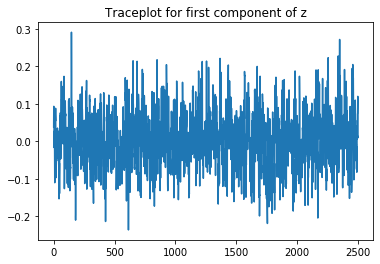

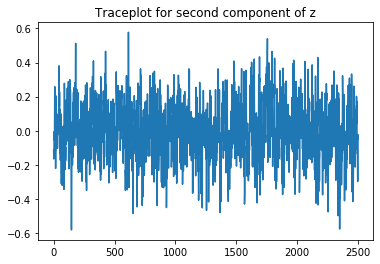

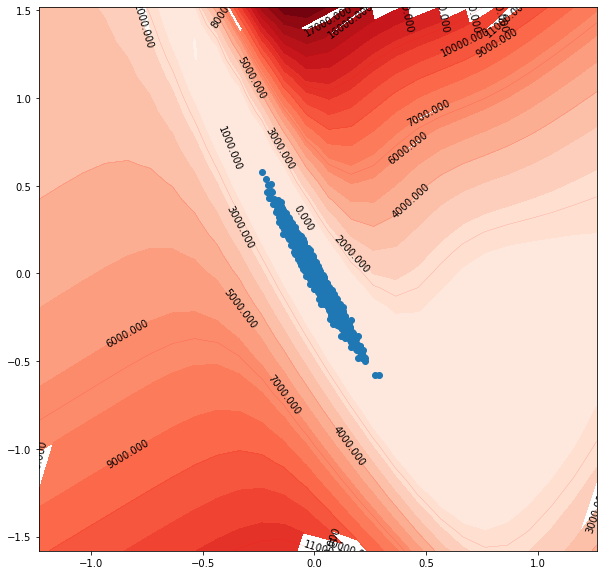

In [16]:
# Traceplots
plt.figure()
plt.title('Traceplot for first component of z')
plt.plot(HMC_sampler_pca.trace[:, 0])

plt.figure()
plt.title('Traceplot for second component of z')
plt.plot(HMC_sampler_pca.trace[:, 1])


# Plot samples in x-y plane over contour map of potential energy (like in paper)
def new_potential_energy_pca(z):
    #print(z)
    return -1 * (log_lklhd(z, P_pca) + log_prior(z))


# Define contour map range (slightly larger than min/max of samples)
x, y = numpy.mgrid[
    min(HMC_sampler_pca.trace[:, 0]) - 1:max(HMC_sampler_pca.trace[:, 0]) + 1:.1, 
    min(HMC_sampler_pca.trace[:, 1]) - 1:max(HMC_sampler_pca.trace[:, 1]) + 1:.1
]
pos = numpy.dstack((x, y))

print(x.shape)
print(y.shape)

# Get the potential energy at the mesh points
z = np.zeros(x.shape)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = new_potential_energy_pca(np.array([x[i, j],y[i, j]]))
    
print(z.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Create the potential energy contour map with labels
CS = ax.contourf(x,y,z, 20, cmap='Reds')
ax.clabel(CS,fontsize=10,colors='black')
ax.contour(x,y,z, linewidths=0.1, colors='red')

# Make scatter plot of HMC samples over contour map
plt.scatter(HMC_sampler_pca.trace[:,0],HMC_sampler_pca.trace[:,1])
plt.show()

Text(0, 0.5, 'y')

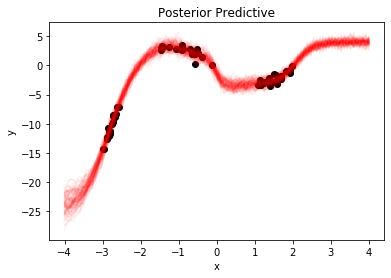

In [17]:
# Take samples of posterior weights
N = len(HMC_sampler_pca.trace)
n_samples = 100

x_test = np.linspace(-4, 4, 100).reshape(1,-1)

# For each of 100 samples, plot output from test data with some noise added
for i in range(n_samples):
    sample = np.array([HMC_sampler_pca.trace[random.randint(N),:]]) # Sample weights
    
    weights = z_to_w(sample, P_pca)
    
    # Use these weights in the NN
    y_test = nn.forward(weights,x_test).flatten()
    y_test += random.normal(0,0.5,size=100) # Add noise to prediction
    
    plt.plot(x_test.flatten(),y_test, color='red',alpha=0.05)
    
# Also plot our original data
plt.scatter(X_train, Y_train, color='black', label='data')  
plt.title('Posterior Predictive')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

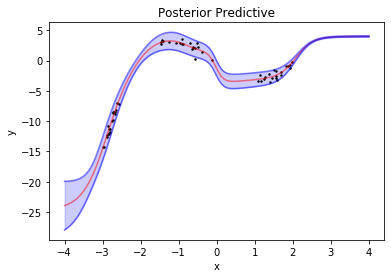

In [18]:
# Make a similar plot, but with predictive mean +/- 3 SDs (like in the paper)
# For each of 100 samples, plot output from test data with some noise added
x_test = np.linspace(-4, 4, 100).reshape(1,-1)

n_samples = 100
all_samples = np.zeros((n_samples,x_test.shape[1]))

for i in range(n_samples):
    sample = np.array([HMC_sampler_pca.trace[random.randint(N),:]]) # Sample weights
    
    weights = z_to_w(sample, P_pca)
    
    # Use these weights in the NN
    all_samples[i,:] = nn.forward(weights,x_test).flatten()

plot1 = np.mean(all_samples,axis=0)  
plot2 = np.mean(all_samples,axis=0)+3*np.std(all_samples,axis=0)
plot3 = np.mean(all_samples,axis=0)-3*np.std(all_samples,axis=0)

plt.plot(x_test.flatten(),plot1, color='red',alpha=0.5)    
plt.plot(x_test.flatten(),plot2, color='blue',alpha=0.5)
plt.plot(x_test.flatten(),plot3, color='blue',alpha=0.5)
plt.fill_between(x_test.flatten(), plot2, plot3, color='blue', alpha=0.2)    

# Also plot our original data
plt.scatter(X_train, Y_train, color='black', label='data', s=2)  
plt.title('Posterior Predictive')
plt.xlabel('x')
plt.ylabel('y')


## HMC on Full Weight Space

In [19]:
D = nn.weights.shape[1]

Sigma_W_fhmc = 5**2 * np.eye(D)
sigma_y_fhmc = 0.5**2
N_fhmc = 60
Sigma_W_inv_fhmc = np.linalg.inv(Sigma_W_fhmc)
Sigma_W_det_fhmc = np.linalg.det(Sigma_W_fhmc)

def log_prior_full_hmc(W):
    assert len(W.shape) == 2 and W.shape[1] == D
    S = len(W)
    constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det_fhmc))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv_fhmc), W.T))
    
    assert exponential_W.shape == (S, )
    
    log_p_W = constant_W + exponential_W
    return log_p_W[0]

def log_lklhd_full_hmc(W):
    assert len(W.shape) == 2 and W.shape[1] == D
    S = W.shape[0]
        
    constant = (-np.log(sigma_y_fhmc) - 0.5 * np.log(2 * np.pi)) * N_fhmc
    Y_eval = nn.forward(W, X_train)
    
    exponential = -0.5 * sigma_y_fhmc**-2 * np.sum((Y_train - Y_eval)**2)
    return constant + exponential

def potential_energy_full_hmc(W):
    return -1 * (log_lklhd_full_hmc(W) + log_prior_full_hmc(W))

def kinetic_energy_full_hmc(W):
    return np.sum(W**2) / 2.0

def kinetic_energy_distribution_full_hmc(n):
    return random.normal(0, 1, size=D)

In [20]:
position_init_fhmc = nn.weights.reshape(1,-1)

step_size_fhmc = 1e-2
leapfrog_steps_fhmc = 10
burn_in_fhmc = 0.2
thinning_factor_fhmc = 5
total_samples_fhmc = 2000


HMC_sampler_fhmc = HMC(potential_energy_full_hmc, kinetic_energy_full_hmc,
                      kinetic_energy_distribution_full_hmc,
                      random=np.random.RandomState(0))

In [21]:
HMC_sampler_fhmc.sample(position_init=position_init_fhmc,
                   step_size=step_size_fhmc,
                   leapfrog_steps=leapfrog_steps_fhmc,
                   total_samples=total_samples_fhmc,
                   burn_in=burn_in_fhmc,
                   thinning_factor=thinning_factor_fhmc)

HMC 100: accept rate of 35.0 with step size 0.01
HMC 200: accept rate of 28.999999999999996 with step size 0.0095
HMC 300: accept rate of 30.666666666666664 with step size 0.009025
HMC 200: accept rate of 39.5
HMC 400: accept rate of 41.5
HMC 600: accept rate of 41.833333333333336
HMC 800: accept rate of 40.125
HMC 1000: accept rate of 36.2
HMC 1200: accept rate of 34.0
HMC 1400: accept rate of 31.071428571428573
HMC 1600: accept rate of 30.125
HMC 1800: accept rate of 29.833333333333332


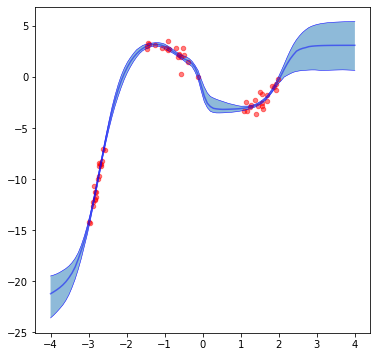

In [22]:
posterior_samples_fhmc = HMC_sampler_fhmc.trace[:100]

X_test = np.linspace(-4, 4, 100).reshape(1,-1)

Ys = []
for sp in posterior_samples_fhmc:
    Y_test = nn.forward(sp.reshape(1,-1), X_test)
    Ys.append(Y_test.flatten())
    
tmp_Y = np.vstack(Ys)

plotY_upper = []
plotY_lower = []
plotY_mean = []
for j in range(100):
    plotY_upper.append(np.percentile(tmp_Y[:,j], 97.5))
    plotY_mean.append(np.percentile(tmp_Y[:,j], 50))
    plotY_lower.append(np.percentile(tmp_Y[:,j], 2.5))
    
plt.figure(figsize=(6,6))
plt.fill_between(X_test.flatten(), plotY_lower, plotY_upper, alpha=0.5)
plt.plot(X_test.flatten(), plotY_lower, c='blue', lw=0.5)
plt.plot(X_test.flatten(), plotY_upper, c='blue', lw=0.5)
plt.plot(X_test.flatten(), plotY_mean, c='blue', alpha=0.5)
plt.scatter(X_train, Y_train, s=20, alpha=0.5, c='r')
plt.show()

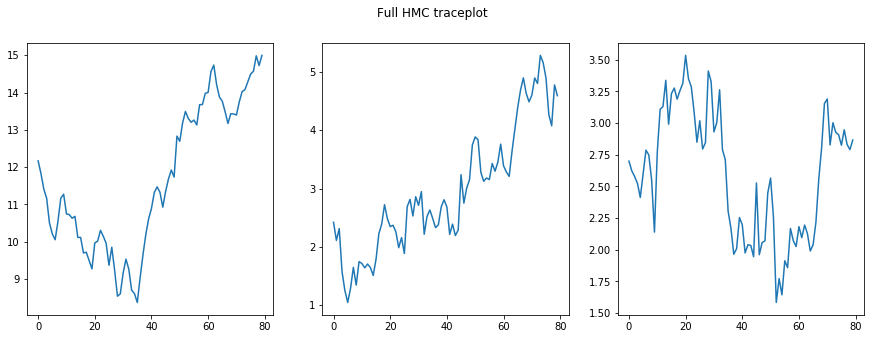

In [23]:
plt.figure(figsize=(15,5))
plt.suptitle('Full HMC traceplot')
plt.subplot(131)
plt.plot(HMC_sampler_fhmc.trace[:,0])
plt.subplot(132)
plt.plot(HMC_sampler_fhmc.trace[:,1])
plt.subplot(133)
plt.plot(HMC_sampler_fhmc.trace[:,2])
plt.show()

# Observations

From our pedagogical example, we see that our bare-bones implementation of PCA subspace inference seems to represent aleatoric uncertainty more accurately than the other methods. It gives wider and more reasonable uncertainty intervals in the posterior predictive than those generated by using random subspace or HMC on the full weight space, suggesting that it is exploring a diverse set of models. However, PCA subspace doesn't do a great job of representing epistemic uncertainty; the intervals are not significantly wider away from regions with a lot of data. One reason this might be the case is that the subspace chosen was not of sufficiently high dimension. Alternatively, HMC might be stuck at one local minimum instead of exploring the whole space; we expect that curve subspace inference might fix this problem.

Another observation that is counterintuitive is that further training of the neural network did not seem to improve the ability of subspace inference to sample a wide variety of models (and therefore its ability to represent epistemic uncertainty). One possible explanation could be the fact that, after further training, the weights found are more likely to be in a deep potential well that HMC has more difficulty escaping so all models sampled are only slight modifications of the pre-trained model.

## Future Work

It would be helpful to develop a metric for how appropriate the level of aleatoric and epistemic uncertainty is, so that we no longer have to rely on visualizations of toy examples. 

The performance of subspace inference also seems to be heavily dependent on the prior distribution and temperature chosen. These two hyperparameters provide flexibility in the model, but finding priors such that the posterior distribution of models represent uncertainty well is not a trivial task. In addition, unlike priors in simpler Bayesian models, the prior distribution and temperature in subspace inference are much more difficult to set with prior knowledge, as explainability (and therefore the impact of the parameters) is much more difficult in deep neural networks.